In [25]:
import pandas as pd
import numpy as np
import urllib.parse
import urllib.request
from tqdm import tqdm
import os
import time
import subprocess
from scipy import stats
import matplotlib.pyplot as plt

def uniprotMapping(query, From="ACC",To="ACC",Format="fasta",Columns="",outputDir=""):
    for i in range(10):
        try:
            url = 'https://www.uniprot.org/uploadlists/'
            params={
                "query":query,
                "from":From,
                "to":To,
                "format":Format,
                "columns":Columns,
            }
            data = urllib.parse.urlencode(params)
            data = data.encode('utf-8')
            req = urllib.request.Request(url, data)
            with urllib.request.urlopen(req) as f:
                response = str(f.read(),encoding="utf-8")
            fileName="{}_{}_{}.{}".format(query.replace("\n",""),From,To,Format)
            outputPath="{}{}".format(outputDir,fileName)
            if outputDir and not os.path.exists(outputDir):
                os.makedirs(outputDir)
            with open(outputPath,"w") as f:
                f.write(response)
            return response
        except:
            print("request failed, wait for", i*5,"seconds and try again")
            time.sleep(i*5)
            
def cdhit(inputFastaFile, identity=0.9, outputDir=""):
    if outputDir and not os.path.exists(outputDir):
        os.makedirs(outputDir)
    outputFile=inputFastaFile.split("/")[-1].replace(".fasta","_cdhit.fasta")
    outputFilePath="{}{}".format(outputDir,outputFile)
    command = "cd-hit -i {} -o {} -c {}".format(inputFastaFile,outputFilePath,identity)
    cmd = subprocess.Popen(command,
                           shell=True,
                           stdin=subprocess.PIPE,
                          stdout=subprocess.PIPE,
                          stderr=subprocess.STDOUT)
    cmd.communicate()
    return outputFilePath

def clustalo(inputFastaFile,outputDir=""):
    if outputDir and not os.path.exists(outputDir):
        os.makedirs(outputDir)
    outputFile=inputFastaFile.split("/")[-1].replace(".fasta","_MSA.fasta")
    outputFilePath="{}{}".format(outputDir,outputFile)
    command = "clustalo -i {} -o {} --force".format(inputFastaFile,outputFilePath)
    cmd = subprocess.Popen(command,
                           shell=True,
                           stdin=subprocess.PIPE,
                          stdout=subprocess.PIPE,
                          stderr=subprocess.STDOUT)
    cmd.communicate()
    return outputFilePath

def parseFasta(fastaFile):
    f=open(fastaFile)
    fastaStr=f.read()
    f.close()
    lol=[entry.replace("\n","toSplit",1).replace("\n","").split("toSplit")
        for entry
        in fastaStr[1:].split(">")]
    lol=[(entry.split("|")[:2][-1],seq) for entry,seq in lol]
    dic={entry:sequence for entry,sequence in lol}
    return dic

def putFirstInFasta(fastaFile,Id):
    dic = parseFasta(fastaFile)
    fastaOrdered = [(key,seq) for key,seq in dic.items() if key==Id] + [(key,seq) for key,seq in dic.items() if key!=Id]
    toWrite=""
    for key,seq in fastaOrdered:
        toWrite+=">{}\n{}\n".format(key,seq)
    with open(fastaFile,"w") as f:
        f.write(toWrite)
        
def getMsaPeridictions(msaFile, verbose=False):
    OutputFile=msaFile.replace(".fasta","_EFoldMine.pred")
    
    command = "python2 efoldminePredictionsMsa.py {} {}".format(msaFile,OutputFile)
    cmd = subprocess.Popen(command,
                           shell=True,
                           stdin=subprocess.PIPE,
                          stdout=subprocess.PIPE,
                          stderr=subprocess.STDOUT)
    if verbose:
        print(cmd.communicate())
    else:
        cmd.communicate()
    return OutputFile

def msaPredictions2Dic(msaPredictionFile):
    with open(msaPredictionFile) as f:
        msaPredictionString=f.read()
    msaPredictionDic=dict()
    for line in msaPredictionString.split("\n"):
        if line.startswith(">"):
            Id=line.replace(">","")
            msaPredictionDic[Id]=dict()
        else:
            if line:
                feature, featureSequence = line.split("\t")
                if feature=="sequence":
                    msaPredictionDic[Id][feature]=featureSequence.split(" ")
                else:
                    msaPredictionDic[Id][feature]=[float(elm) 
                                                   for elm 
                                                   in featureSequence.split(" ")]
    return msaPredictionDic

def findRelPosInMsa(msaSeq, pos):
        seq = msaSeq
        msaPos=0
        i=0
        while i<=pos:
            msaPos+=1
            if seq[msaPos]!="-":
                i+=1
        return msaPos
    
def cutPredictions(predictionDic,start=None,end=None):
    predictionDicNew=dict()
    for ID in predictionDic.keys():
        predictionDicNew[ID]=dict()
        for feature,seqList in predictionDic[ID].items():
            predictionDicNew[ID][feature]=seqList[start:end]
    return predictionDicNew

def writePredictions2File(predictionDic,fileName):
    with open(fileName,"w") as f:
        for ID in predictionDic.keys():
            f.write(">{}\n".format(ID))
            for feature,seqList in predictionDic[ID].items():
                seqListOfStrings=map(str,seqList)
                seqStr=" ".join(seqListOfStrings)
                f.write("{}\t{}\n".format(feature,seqStr))
    return fileName

def msaPredictionsDic2Arrays(msaPredictionDic):
    Ids =  sorted(msaPredictionDic.keys())
    features = sorted(msaPredictionDic[Ids[0]].keys())
    cols = len(msaPredictionDic[Ids[0]][features[0]])
    rows = len(Ids)
    
    dicOfArrays=dict()
    for feature in features:
        if feature=="sequence":
            dicOfArrays[feature]=np.zeros((rows,cols),dtype=str)
            dicOfArrays[feature][:,:]="-"
        else:
            dicOfArrays[feature]=np.zeros((rows,cols),dtype=float)
            dicOfArrays[feature][:,:]=np.nan
            
    for i,Id in enumerate(Ids):
        for feature in features:
            dicOfArrays[feature][i,:]=msaPredictionDic[Id][feature]
    return dicOfArrays

def wilcoxonRanksumTest(periplasm,cytoplasm,pValue=5e-2,minDataSize=10):
    features = [feature for feature in periplasm.keys() if feature!="sequence"]
    rows, cols = periplasm[features[0]].shape
    
    wilcoxonResults=dict()
    
    for feature in features:
        wilcoxonResults[feature]=list()
        for i in range(cols):
            cytoData=[value for value in cytoplasm[feature][:,i] if not np.isnan(value)]
            periData=[value for value in periplasm[feature][:,i] if not np.isnan(value)]
            if len(cytoData)<minDataSize or len(periData)<minDataSize:
                wilcoxonResults[feature].append(float("nan"))
            else:
                statistic, pValue_observed = stats.ranksums(cytoData,periData)
                if pValue_observed > pValue:
                    wilcoxonResults[feature].append(0)
                else:
                    wilcoxonResults[feature].append(statistic)
    return wilcoxonResults

def getMedian(wilcoxonResults):
    arrays=dict()
    ids = sorted(wilcoxonResults.keys())
    features= sorted(wilcoxonResults[ids[0]])
    longest = max(map(len, [wilcoxonResults[Id][features[0]] for Id in ids]))
    for feature in features:
        arrays[feature]=np.zeros((len(ids),longest))
        arrays[feature][:,:]=np.nan
    for i,Id in enumerate(ids):
        for feature in features:
            values = wilcoxonResults[Id][feature]
            arrays[feature][i,:len(values)]=values
    medians=dict()
    for i,Id in enumerate(ids):
        for feature in features:
            medians[feature]=np.nanmedian(arrays[feature],axis=0)
    return medians

def getPercentile(wilcoxonResults, percentile=25):
    arrays=dict()
    ids = sorted(wilcoxonResults.keys())
    features= sorted(wilcoxonResults[ids[0]])
    longest = max(map(len, [wilcoxonResults[Id][features[0]] for Id in ids]))
    for feature in features:
        arrays[feature]=np.zeros((len(ids),longest))
        arrays[feature][:,:]=np.nan
    for i,Id in enumerate(ids):
        for feature in features:
            values = wilcoxonResults[Id][feature]
            arrays[feature][i,:len(values)]=values
    Percentile=dict()
    for i,Id in enumerate(ids):
        for feature in features:
            Percentile[feature]=np.nanpercentile(arrays[feature],percentile,axis=0)
    return Percentile

def writeWilcoxonResults(file,wilcoxonResults,cyto_id, peri_id):
    f=open(file,"a")
    f.write(">{}|{}\n".format(cyto_id, peri_id))
    for feature,sequence in wilcoxonResults.items():
        sequenceString=" ".join([str(elm) for elm in sequence])
        f.write("{}\t{}\n".format(feature,sequenceString))
    f.close()

TWINS = pd.read_csv("../2020-05-12.wilcoxon-ranksum-test/twins_info.tab",sep="\t",index_col=0).reset_index(drop=True)
TWINS

,Cytoplasm,Periplasm,Organism,SP_start,SP_end,Cytoplasm_uniref50,Cytoplasm_uniref50_size,Periplasm_uniref50,Periplasm_uniref50_size,Cytoplasm_length,Periplasm_length,length_ratio,length_abs_diff
0,A0A169XQ31,A0A2I8WC74,Klebsiella_oxytoca,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,582,1.000000,0
1,A0A169XQ31,A0A0G3S663,Klebsiella_oxytoca,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,582,1.000000,0
2,A0A169XQ31,A0A3E1SVQ6,Klebsiella_oxytoca,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,582,1.000000,0
3,A0A169XQ31,A0A384I9X6,Klebsiella_oxytoca,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,582,1.000000,0
4,A0A169XQ31,A0A168N292,Klebsiella_oxytoca,1,34,UniRef50_P62602,2175,UniRef50_Q8XDH7,3943,549,582,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27634,A0A2V9DP80,A0A3N5ZMI4,Acidobacteria_bacterium,1,19,UniRef50_A0A317I3X7,20,UniRef50_A0A3N5ZMI4,1,1161,349,0.285099,830
27635,A0A2V9QGT4,A0A3N5ZMI4,Acidobacteria_bacterium,1,19,UniRef50_A0A522PXJ5,10,UniRef50_A0A3N5ZMI4,1,1177,349,0.281223,846
27636,A0A522PXJ5,A0A3N5ZMI4,Acidobacteria_bacterium,1,19,UniRef50_A0A522PXJ5,10,UniRef50_A0A3N5ZMI4,1,1179,349,0.280746,848
27637,A0A522PXJ5,A0A3N5ZMI4,Acidobacteria_bacterium,1,19,UniRef50_A0A522PXJ5,10,UniRef50_A0A3N5ZMI4,1,1179,349,0.280746,848


In [2]:
"""Get Info of all the Twins"""
TWINS = pd.read_csv("../2020-05-12.wilcoxon-ranksum-test/twins_info.tab",sep="\t",index_col=0).reset_index(drop=True)

"""Keep Twins with two different Uniref50 groups"""
TWINS = TWINS[TWINS["Cytoplasm_uniref50"]!=TWINS["Periplasm_uniref50"]].reset_index(drop=True).reset_index(drop=True)

"""Keep Twins with length ratio > ratio_thr"""
ratio_thr=0.75
TWINS = TWINS[TWINS["length_ratio"]>ratio_thr].reset_index(drop=True)

"""Keep Twins abs diff<abs_thr"""
#abs_thr=50
#TWINS = TWINS[TWINS["length_abs_diff"]<abs_thr].reset_index(drop=True)

"""Reduce to unique groups"""
print("Unique cytoplasm uniref50 groups:", len(TWINS["Cytoplasm_uniref50"].unique()))
print("Unique periplasm uniref50 groups:", len(TWINS["Periplasm_uniref50"].unique()))
#TWINS.sort_values("length_ratio",ascending=False).groupby(["Cytoplasm_uniref50","Periplasm_uniref50"],as_index=True).first()
TWINS=TWINS.sort_values(["Periplasm_uniref50_size"],ascending=False).groupby("Cytoplasm_uniref50",as_index=False).first()
TWINS=TWINS.sort_values(["Cytoplasm_uniref50_size"],ascending=False).groupby("Periplasm_uniref50",as_index=False).first()
TWINS

Unique cytoplasm uniref50 groups: 20
Unique periplasm uniref50 groups: 21


,Periplasm_uniref50,Cytoplasm_uniref50,Cytoplasm,Periplasm,Organism,SP_start,SP_end,Cytoplasm_uniref50_size,Periplasm_uniref50_size,Cytoplasm_length,Periplasm_length,length_ratio,length_abs_diff
0,UniRef50_A0A1X1D1X1,UniRef50_Q2NVU4,A0A484WTL8,A0A0A3ZPT1,Enterobacter_cancerogenus,1,35,124,148,171,166,0.771930,39
1,UniRef50_O53021,UniRef50_P83221,P23869,P0AFL3,Escherichia_coli_strain_K12,1,24,4189,2118,164,190,0.982036,3
2,UniRef50_O59651,UniRef50_Q96VT4,Q9ZGM4,Q9WXB9,Legionella_pneumophila,1,27,1678,9906,721,749,0.997234,2
3,UniRef50_P00805,UniRef50_P0A963,P0A962,P00805,Escherichia_coli_strain_K12,1,22,3836,2537,338,348,0.967456,11
4,UniRef50_P0AAL4,UniRef50_P0AAL2,A0A3T8GC16,P0AAL5,Shigella_flexneri,1,41,1270,492,164,231,0.858639,27
5,UniRef50_P0C278,UniRef50_P10902,Q8EH88,P83223,Shewanella_oneidensis_strain_MR-1,1,25,6730,160,537,596,0.938811,35
6,UniRef50_P25718,UniRef50_P21517,P21517,P25718,Escherichia_coli_strain_K12,1,17,4496,5447,604,676,0.915152,56
7,UniRef50_P39185,UniRef50_O33732,O33732,Q080C0,Shewanella_frigidimarina_strain_NCIMB_400,1,27,29,6749,938,829,0.856077,135
8,UniRef50_P44652,UniRef50_P44650,P44650,P44652,Haemophilus_influenzae_strain_ATCC_51907__DSM_...,1,50,243,304,176,279,0.765217,54
9,UniRef50_P45523,UniRef50_P0A9L3,P0A9L3,P45523,Escherichia_coli_strain_K12,1,25,1427,2225,206,270,0.837398,40


In [3]:
"""
Not all protein Ids map to themselve, so first it is necessary to map to the protein id itself
"""
for INDEX, ROW in TWINS.iterrows():
    print()
    CYTO_ID = ROW["Cytoplasm"]
    PERI_ID = ROW["Periplasm"]
    TWIN_DIR = "{}_{}/".format(CYTO_ID,PERI_ID)
    print("Download uniref ID of cytoplasmic protein", CYTO_ID)
    print("\t",uniprotMapping(CYTO_ID, From="ACC", To="ACC", Format="list", outputDir="{}{}".format(TWIN_DIR,"Cytoplasm/")))
    print("Download uniref ID of periplasmic protein", PERI_ID)
    print("\t",uniprotMapping(PERI_ID, From="ACC", To="ACC", Format="list", outputDir="{}{}".format(TWIN_DIR,"Periplasm/")))


Download uniref ID of cytoplasmic protein A0A484WTL8
	 A0A484WTL8

Download uniref ID of periplasmic protein A0A0A3ZPT1
	 A0A0A3ZPT1


Download uniref ID of cytoplasmic protein P23869
	 P23869

Download uniref ID of periplasmic protein P0AFL3
	 P0AFL3


Download uniref ID of cytoplasmic protein Q9ZGM4
	 Q9ZGM4

Download uniref ID of periplasmic protein Q9WXB9
	 Q9WXB9


Download uniref ID of cytoplasmic protein P0A962
	 P0A962

Download uniref ID of periplasmic protein P00805
	 P00805


Download uniref ID of cytoplasmic protein A0A3T8GC16
	 A0A3T8GC16

Download uniref ID of periplasmic protein P0AAL5
	 P0AAL5


Download uniref ID of cytoplasmic protein Q8EH88
	 Q8EH88

Download uniref ID of periplasmic protein P83223
	 P83223


Download uniref ID of cytoplasmic protein P21517
	 P21517

Download uniref ID of periplasmic protein P25718
	 P25718


Download uniref ID of cytoplasmic protein O33732
	 O33732

Download uniref ID of periplasmic protein Q080C0
	 Q080C0


Download uniref ID of c

In [4]:
"""
Look at Uniprot Ids and download uniref50 Ids for both Cytoplasmic and periplasmic proteins.
"""
for DIR in [D for D in os.listdir("./") if D.count(".")==0 and D.count("b2bTools")==0]:
    print()
    for SUBDIR in [D for D in os.listdir(DIR) if D.count(".")==0]:
        SUBDIR_PATH="{}/{}/".format(DIR,SUBDIR)
        for FILE in [F for F in os.listdir(SUBDIR_PATH) if F.count("_ACC_ACC.list")>0]:
            FILE_PATH="{}{}".format(SUBDIR_PATH,FILE)
            with open(FILE_PATH) as F:
                QUERY=F.read()
            print("Download uniref50 group Id of", QUERY.replace("\n",""))
            RESPONSE=uniprotMapping(QUERY, From="ACC", To="NF50", Format="list",outputDir=SUBDIR_PATH)
            print(RESPONSE)


Download uniref50 group Id of P00805
UniRef50_P00805

Download uniref50 group Id of P0A962
UniRef50_P0A963


Download uniref50 group Id of A0A2K3TM34
UniRef50_Q8XDH7

Download uniref50 group Id of A0A368ING8
UniRef50_P62602


Download uniref50 group Id of Q080C0
UniRef50_P39185

Download uniref50 group Id of O33732
UniRef50_O33732


Download uniref50 group Id of A0A1X1M0G1
UniRef50_Q8ZRT8

Download uniref50 group Id of A0A237NMK1
UniRef50_Q32JZ5


Download uniref50 group Id of P0AFL3
UniRef50_O53021

Download uniref50 group Id of P23869
UniRef50_P83221


Download uniref50 group Id of A0A3W3WI41
UniRef50_Q32JZ5

Download uniref50 group Id of W9BJ44
UniRef50_Q8ZRT8


Download uniref50 group Id of Q72EC8
UniRef50_Q72EC8

Download uniref50 group Id of Q72CB8
UniRef50_Q72CB8


Download uniref50 group Id of P0AAL5
UniRef50_P0AAL4

Download uniref50 group Id of A0A3T8GC16
UniRef50_P0AAL2


Download uniref50 group Id of A0A0A3ZPT1
UniRef50_A0A1X1D1X1

Download uniref50 group Id of A0A484WTL8


In [5]:
"""Use the UniRef50 groups to retrieve members"""
for DIR in [D for D in os.listdir("./") if D.count(".")==0 and D.count("b2bTools")==0]:
    print()
    for SUBDIR in [D for D in os.listdir(DIR) if D.count(".")==0]:
        SUBDIR_PATH="{}/{}/".format(DIR,SUBDIR)
        for FILE in [F for F in os.listdir(SUBDIR_PATH) if F.count("_ACC_NF50.list")>0]:
            FILE_PATH="{}{}".format(SUBDIR_PATH,FILE)
            with open(FILE_PATH) as F:
                QUERY=F.read()
            print("Getting members of group", QUERY.replace("\n",""))
            RESPONSE=uniprotMapping(QUERY, From="NF50", To="ACC", Format="fasta",outputDir=SUBDIR_PATH)
            print("\t",RESPONSE.count(">"), "members")


Getting members of group UniRef50_P00805
	 1574 members
Getting members of group UniRef50_P0A963
	 2462 members

Getting members of group UniRef50_Q8XDH7
	 1684 members
Getting members of group UniRef50_P62602
	 1189 members

Getting members of group UniRef50_P39185
	 3501 members
Getting members of group UniRef50_O33732
	 12 members

Getting members of group UniRef50_Q8ZRT8
	 788 members
Getting members of group UniRef50_Q32JZ5
	 433 members

Getting members of group UniRef50_O53021
	 1466 members
Getting members of group UniRef50_P83221
	 3219 members

Getting members of group UniRef50_Q32JZ5
	 433 members
Getting members of group UniRef50_Q8ZRT8
	 788 members

Getting members of group UniRef50_Q72EC8
	 12 members
Getting members of group UniRef50_Q72CB8
	 18 members

Getting members of group UniRef50_P0AAL4
	 308 members
Getting members of group UniRef50_P0AAL2
	 916 members

Getting members of group UniRef50_A0A1X1D1X1
	 58 members
Getting members of group UniRef50_Q2NVU4
	 66 mem

In [6]:
"""Extract representative from fasta"""
for DIR in [D for D in os.listdir("./") if D.count(".")==0 and D.count("b2bTools")==0]:
    for SUBDIR in [D for D in os.listdir(DIR) if D.count(".")==0]:
        SUBDIR_PATH="{}/{}/".format(DIR,SUBDIR)
        ID_FILE = [F for F in os.listdir(SUBDIR_PATH) if F.count("_ACC_ACC.list")>0][0]
        ID_FILE_PATH="{}{}".format(SUBDIR_PATH,ID_FILE)
        with open(ID_FILE_PATH) as F:
            ID=F.read().replace("\n","")
        FASTA_FILE=[F for F in os.listdir(SUBDIR_PATH) if F.count("_NF50_ACC.fasta")>0][0]
        FASTA_PATH="{}{}".format(SUBDIR_PATH,FASTA_FILE)
        FASTA_DIC=parseFasta(FASTA_PATH)
        OUTPUT_FILE_PATH="{}{}_representative.fasta".format(SUBDIR_PATH,ID)
        with open(OUTPUT_FILE_PATH,"w") as F:
            toWrite=">{}\n{}\n".format(ID,FASTA_DIC[ID])
            F.write(toWrite)

In [7]:
"""Reduce sequential redundance with CD-HIT"""
IDENTITY=0.9
for DIR in [D for D in os.listdir("./") if D.count(".")==0 and D.count("b2bTools")==0]:
    print()
    for SUBDIR in [D for D in os.listdir(DIR) if D.count(".")==0]:
        SUBDIR_PATH="{}/{}/".format(DIR,SUBDIR)
        for FILE in [F for F in os.listdir(SUBDIR_PATH) if F.count("_NF50_ACC.fasta")>0]:
            FILE_PATH="{}{}".format(SUBDIR_PATH,FILE)
            print("Reducing members of",SUBDIR,FILE,"with to max sequence identity of",IDENTITY)
            OUTPUT_FILE = cdhit(FILE_PATH, identity=IDENTITY, outputDir=SUBDIR_PATH)
            with open(FILE_PATH) as F:
                MEMBERS_INPUT=F.read().count(">")
            with open(OUTPUT_FILE) as F:
                MEMBERS_OUTPUT=F.read().count(">")
            print( MEMBERS_OUTPUT,"\t/\t",MEMBERS_INPUT)
            


Reducing members of Periplasm UniRef50_P00805_NF50_ACC.fasta with to max sequence identity of 0.9
105 	/	 1574
Reducing members of Cytoplasm UniRef50_P0A963_NF50_ACC.fasta with to max sequence identity of 0.9
258 	/	 2462

Reducing members of Periplasm UniRef50_Q8XDH7_NF50_ACC.fasta with to max sequence identity of 0.9
91 	/	 1684
Reducing members of Cytoplasm UniRef50_P62602_NF50_ACC.fasta with to max sequence identity of 0.9
41 	/	 1189

Reducing members of Periplasm UniRef50_P39185_NF50_ACC.fasta with to max sequence identity of 0.9
512 	/	 3501
Reducing members of Cytoplasm UniRef50_O33732_NF50_ACC.fasta with to max sequence identity of 0.9
10 	/	 12

Reducing members of Periplasm UniRef50_Q8ZRT8_NF50_ACC.fasta with to max sequence identity of 0.9
18 	/	 788
Reducing members of Cytoplasm UniRef50_Q32JZ5_NF50_ACC.fasta with to max sequence identity of 0.9
80 	/	 433

Reducing members of Periplasm UniRef50_O53021_NF50_ACC.fasta with to max sequence identity of 0.9
85 	/	 1466
Reduci

In [8]:
"""Add representative to CDHIT sequences"""
for DIR in [D for D in os.listdir("./") if D.count(".")==0 and D.count("b2bTools")==0]:
    print()
    for SUBDIR in [D for D in os.listdir(DIR) if D.count(".")==0]:
        SUBDIR_PATH="{}/{}/".format(DIR,SUBDIR)
        FILE_CDHIT =[F for F in os.listdir(SUBDIR_PATH) if F.count("cdhit.fasta")>0 and F.count(".clstr")==0][0]
        FILE_CDHIT_PATH="{}{}".format(SUBDIR_PATH,FILE_CDHIT)
        FILE_REPR = [F for F in os.listdir(SUBDIR_PATH) if F.count("_representative.fasta")>0][0]
        FILE_REPR_PATH="{}{}".format(SUBDIR_PATH,FILE_REPR)
        DIC_CDHIT=parseFasta(FILE_CDHIT_PATH)
        DIC_REPR=parseFasta(FILE_REPR_PATH)
        toWrite=""
        for key,value in DIC_REPR.items():
            toWrite+=">{}\n{}\n".format(key,value)
        for key,value in DIC_CDHIT.items():
            toWrite+=">{}\n{}\n".format(key,value)
        OUTPUT_PATH=FILE_CDHIT_PATH.replace(".fasta","_repr.fasta")
        with open(OUTPUT_PATH,"w") as F:
            F.write(toWrite)
        DIC_COMB=parseFasta(OUTPUT_PATH)
        print("Added presentative to",FILE_CDHIT,", number of sequences:",len(DIC_COMB))


Added presentative to UniRef50_P00805_NF50_ACC_cdhit.fasta , number of sequences: 106
Added presentative to UniRef50_P0A963_NF50_ACC_cdhit.fasta , number of sequences: 259

Added presentative to UniRef50_Q8XDH7_NF50_ACC_cdhit.fasta , number of sequences: 92
Added presentative to UniRef50_P62602_NF50_ACC_cdhit.fasta , number of sequences: 42

Added presentative to UniRef50_P39185_NF50_ACC_cdhit.fasta , number of sequences: 513
Added presentative to UniRef50_O33732_NF50_ACC_cdhit.fasta , number of sequences: 10

Added presentative to UniRef50_Q8ZRT8_NF50_ACC_cdhit.fasta , number of sequences: 19
Added presentative to UniRef50_Q32JZ5_NF50_ACC_cdhit.fasta , number of sequences: 81

Added presentative to UniRef50_O53021_NF50_ACC_cdhit.fasta , number of sequences: 86
Added presentative to UniRef50_P83221_NF50_ACC_cdhit.fasta , number of sequences: 979

Added presentative to UniRef50_Q32JZ5_NF50_ACC_cdhit.fasta , number of sequences: 81
Added presentative to UniRef50_Q8ZRT8_NF50_ACC_cdhit.fa

In [9]:
"""Allign sequences into MSA"""
for DIR in [D for D in os.listdir("./") if D.count(".")==0 and D.count("b2bTools")==0]:
    print()
    for SUBDIR in [D for D in os.listdir(DIR) if D.count(".")==0]:
        SUBDIR_PATH="{}/{}/".format(DIR,SUBDIR)
        for FILE in [F for F in os.listdir(SUBDIR_PATH) if F.count("cdhit_repr.fasta")>0]:
            FILE_PATH="{}{}".format(SUBDIR_PATH,FILE)
            with open(FILE_PATH) as INPUT:
                INPUT_N=INPUT.read().count(">")            
            print("Generating MSA for",SUBDIR,FILE,":",INPUT_N,"sequences.")            
            OUTPUT_FILE=clustalo(FILE_PATH, outputDir=SUBDIR_PATH)
            with open(OUTPUT_FILE) as OUTPUT:
                OUTPUT_N=OUTPUT.read().count(">")
            print("\t",OUTPUT_N,"sequences are aligned.")
            with open(FILE_PATH) as F:
                INPUT_LEN = len(F.read().split(">")[1].split("\n",1)[1].replace("\n",""))
            with open(OUTPUT_FILE) as F:
                OUTPUT_LEN = len(F.read().split(">")[1].split("\n",1)[1].replace("\n",""))
            print("\t sequence length with gabs:",INPUT_LEN,"-->",OUTPUT_LEN)  


Generating MSA for Periplasm UniRef50_P00805_NF50_ACC_cdhit_repr.fasta : 106 sequences.
	 106 sequences are aligned.
	 sequence length with gabs: 348 --> 444
Generating MSA for Cytoplasm UniRef50_P0A963_NF50_ACC_cdhit_repr.fasta : 259 sequences.
	 259 sequences are aligned.
	 sequence length with gabs: 338 --> 476

Generating MSA for Periplasm UniRef50_Q8XDH7_NF50_ACC_cdhit_repr.fasta : 92 sequences.
	 92 sequences are aligned.
	 sequence length with gabs: 565 --> 739
Generating MSA for Cytoplasm UniRef50_P62602_NF50_ACC_cdhit_repr.fasta : 42 sequences.
	 42 sequences are aligned.
	 sequence length with gabs: 549 --> 711

Generating MSA for Periplasm UniRef50_P39185_NF50_ACC_cdhit_repr.fasta : 513 sequences.
	 513 sequences are aligned.
	 sequence length with gabs: 829 --> 1156
Generating MSA for Cytoplasm UniRef50_O33732_NF50_ACC_cdhit_repr.fasta : 11 sequences.
	 11 sequences are aligned.
	 sequence length with gabs: 938 --> 1015

Generating MSA for Periplasm UniRef50_Q8ZRT8_NF50_AC

In [10]:
"""If necessarym here come some additional filters, maybe on signal peptide"""

'If necessarym here come some additional filters, maybe on signal peptide'

In [11]:
""" Align MSA of Cytoplasm to MSA of Periplasm"""
for DIR in [D for D in os.listdir("./") if D.count(".")==0 and D.count("b2bTools")==0]:
    print()
    FASTA_PATH_TEMP="{}/{}.fasta".format(DIR,DIR)
    FT=open(FASTA_PATH_TEMP,"w")
    for SUBDIR in [D for D in os.listdir(DIR) if D.count(".")==0]:
        SUBDIR_PATH="{}/{}/".format(DIR,SUBDIR)
        for FILE in [F for F in os.listdir(SUBDIR_PATH) if F.count("cdhit_repr_MSA.fasta")>0]:
            FILE_PATH="{}{}".format(SUBDIR_PATH,FILE)
            with open(FILE_PATH) as F:
                INPUT = F.read()
                INPUT_LEN=INPUT.count(">")
                print("Adding",FILE,"to",FASTA_PATH_TEMP,"\n\t(",INPUT_LEN,"sequences)")
                FT.write(INPUT)
    FT.write("\n")
    FT.close()
    print("Aligning Cytoplasmic proteins to Periplasmic proteins")
    OUTPUT_FILE=clustalo(FASTA_PATH_TEMP, outputDir=DIR+"/")
    with open(OUTPUT_FILE) as F:
        OUTPUT_LEN=F.read().count(">")
        print("\t(",OUTPUT_LEN,"sequences)")
    os.remove(FASTA_PATH_TEMP)
            


Adding UniRef50_P00805_NF50_ACC_cdhit_repr_MSA.fasta to P0A962_P00805/P0A962_P00805.fasta 
	( 106 sequences)
Adding UniRef50_P0A963_NF50_ACC_cdhit_repr_MSA.fasta to P0A962_P00805/P0A962_P00805.fasta 
	( 259 sequences)
Aligning Cytoplasmic proteins to Periplasmic proteins
	( 365 sequences)

Adding UniRef50_Q8XDH7_NF50_ACC_cdhit_repr_MSA.fasta to A0A368ING8_A0A2K3TM34/A0A368ING8_A0A2K3TM34.fasta 
	( 92 sequences)
Adding UniRef50_P62602_NF50_ACC_cdhit_repr_MSA.fasta to A0A368ING8_A0A2K3TM34/A0A368ING8_A0A2K3TM34.fasta 
	( 42 sequences)
Aligning Cytoplasmic proteins to Periplasmic proteins
	( 134 sequences)

Adding UniRef50_P39185_NF50_ACC_cdhit_repr_MSA.fasta to O33732_Q080C0/O33732_Q080C0.fasta 
	( 513 sequences)
Adding UniRef50_O33732_NF50_ACC_cdhit_repr_MSA.fasta to O33732_Q080C0/O33732_Q080C0.fasta 
	( 11 sequences)
Aligning Cytoplasmic proteins to Periplasmic proteins
	( 524 sequences)

Adding UniRef50_Q8ZRT8_NF50_ACC_cdhit_repr_MSA.fasta to A0A237NMK1_A0A1X1M0G1/A0A237NMK1_A0A1X1M0

In [12]:
"""Cut Signal peptides from MSA sequences"""
for DIR in [D for D in os.listdir("./") if D.count(".")==0 and D.count("b2bTools")==0]:
    print()
    PERI_ID=DIR.split("_")[1]
    print("Cutting signal peptide from MSA",DIR)
    for FILE in [F for F in os.listdir(DIR) if F.count("_MSA.fasta")>0]:
        FILE_PATH="{}/{}".format(DIR,FILE)
        MSA_DIC=parseFasta(FILE_PATH)
        MSA_REPR_SEQ=MSA_DIC[PERI_ID]
        NEW_START_IN_SEQ=int(TWINS[TWINS["Periplasm"]==PERI_ID]["SP_end"].unique()[0])
        NEW_START_IN_MSA = findRelPosInMsa(MSA_REPR_SEQ, NEW_START_IN_SEQ)
        MSA_DIC_CUT={KEY:SEQ[NEW_START_IN_MSA:] for KEY,SEQ in MSA_DIC.items()}
        OLD_SEQ_LEN=len(MSA_DIC[sorted(MSA_DIC.keys())[0]])
        NEW_SEQ_LEN=len(MSA_DIC_CUT[sorted(MSA_DIC_CUT.keys())[0]])
        print("\t",OLD_SEQ_LEN,"-->",NEW_SEQ_LEN)
        OUTPUT_FILE=FILE_PATH.replace(".fasta","_cut.fasta")
        with open(OUTPUT_FILE,"w") as F:
            for KEY,VALUE in MSA_DIC_CUT.items():
                if len(VALUE.replace("-",""))>50:
                    F.write(">{}\n{}\n".format(KEY,VALUE))
        


Cutting signal peptide from MSA P0A962_P00805
	 533 --> 413

Cutting signal peptide from MSA A0A368ING8_A0A2K3TM34
	 833 --> 714

Cutting signal peptide from MSA O33732_Q080C0
	 1333 --> 1269

Cutting signal peptide from MSA A0A237NMK1_A0A1X1M0G1
	 263 --> 161

Cutting signal peptide from MSA P23869_P0AFL3
	 272 --> 221

Cutting signal peptide from MSA A0A4V0HDT9_A0A3W3WI41
	 262 --> 162

Cutting signal peptide from MSA Q72CB8_Q72EC8
	 373 --> 308

Cutting signal peptide from MSA A0A3T8GC16_P0AAL5
	 306 --> 247

Cutting signal peptide from MSA A0A484WTL8_A0A0A3ZPT1
	 254 --> 163

Cutting signal peptide from MSA Q9ZGM4_Q9WXB9
	 1675 --> 1142

Cutting signal peptide from MSA Q8EH88_P83223
	 1006 --> 970

Cutting signal peptide from MSA P0A9L3_P45523
	 425 --> 341

Cutting signal peptide from MSA P21517_P25718
	 959 --> 874

Cutting signal peptide from MSA Q7M8K1_Q7M827
	 663 --> 614

Cutting signal peptide from MSA P44650_P44652
	 401 --> 296

Cutting signal peptide from MSA P12994_P773

In [13]:
"""Get predictions for all the combined MSA files"""
for DIR in [D for D in os.listdir("./") if D.count(".")==0 and D.count("b2bTools")==0]:
    print()
    for FILE in [F for F in os.listdir(DIR) if F.count("_MSA_cut.fasta")>0]:
        FILE_PATH="{}/{}".format(DIR,FILE)
        print("generating predictions for",FILE)
        OUTPUT_FILE= getMsaPeridictions(FILE_PATH,verbose=False)
        with open(OUTPUT_FILE) as F:
            LEN=F.read().count(">")
        print("\t({} sequences)".format(LEN))


generating predictions for P0A962_P00805_MSA_cut.fasta
	(362 sequences)

generating predictions for A0A368ING8_A0A2K3TM34_MSA_cut.fasta
	(133 sequences)

generating predictions for O33732_Q080C0_MSA_cut.fasta
	(523 sequences)

generating predictions for A0A237NMK1_A0A1X1M0G1_MSA_cut.fasta
	(100 sequences)

generating predictions for P23869_P0AFL3_MSA_cut.fasta
	(1064 sequences)

generating predictions for A0A4V0HDT9_A0A3W3WI41_MSA_cut.fasta
	(100 sequences)

generating predictions for Q72CB8_Q72EC8_MSA_cut.fasta
	(20 sequences)

generating predictions for A0A3T8GC16_P0AAL5_MSA_cut.fasta
	(41 sequences)

generating predictions for A0A484WTL8_A0A0A3ZPT1_MSA_cut.fasta
	(34 sequences)

generating predictions for Q9ZGM4_Q9WXB9_MSA_cut.fasta
	(3551 sequences)

generating predictions for Q8EH88_P83223_MSA_cut.fasta
	(637 sequences)

generating predictions for P0A9L3_P45523_MSA_cut.fasta
	(99 sequences)

generating predictions for P21517_P25718_MSA_cut.fasta
	(182 sequences)

generating predi

In [14]:
"""Split Periplasmic and Cytoplasmic predictions"""
for DIR in [D for D in os.listdir("./") if D.count(".")==0 and D.count("b2bTools")==0]:
    print()
    PERI_PATH="{}/{}/".format(DIR,"Periplasm")
    PERI_FASTA=[F for F in os.listdir(PERI_PATH) if F.count("_NF50_ACC.fasta")][0]
    PERI_FASTA_PATH="{}{}".format(PERI_PATH,PERI_FASTA)
    with open(PERI_FASTA_PATH) as F:
        PERI_IDS = [L.split("|")[1] for L in F.readlines() if L.startswith(">")]
    
    CYTO_PATH="{}/{}/".format(DIR,"Cytoplasm")
    CYTO_FASTA=[F for F in os.listdir(CYTO_PATH) if F.count("_NF50_ACC.fasta")][0]
    CYTO_FASTA_PATH="{}{}".format(CYTO_PATH,CYTO_FASTA)
    with open(CYTO_FASTA_PATH) as F:
        CYTO_IDS = [L.split("|")[1] for L in F.readlines() if L.startswith(">")]
    
    PRED_FILE=[F for F in os.listdir(DIR) if F.count("_MSA_cut_EFoldMine.pred")][0]
    PRED_PATH="{}/{}".format(DIR,PRED_FILE)
    
    PRED_DIC_ALL=msaPredictions2Dic(PRED_PATH)
    PRED_DIC_ALL_LEN=len(PRED_DIC_ALL)
    
    PRED_DIC_CYTO = {KEY:VALUE for KEY,VALUE in PRED_DIC_ALL.items() if KEY in CYTO_IDS}
    PRED_DIC_CYTO_LEN=len(PRED_DIC_CYTO)
    PRED_CYTO_FILE="{}{}".format(CYTO_PATH,CYTO_FASTA.replace(".fasta","_MSA_cut.pred"))
    writePredictions2File(PRED_DIC_CYTO,PRED_CYTO_FILE)
    
    PRED_DIC_PERI = {KEY:VALUE for KEY,VALUE in PRED_DIC_ALL.items() if KEY in PERI_IDS}
    PRED_DIC_PERI_LEN=len(PRED_DIC_PERI)
    PRED_PERI_FILE="{}{}".format(PERI_PATH,PERI_FASTA.replace(".fasta","_MSA_cut.pred"))
    writePredictions2File(PRED_DIC_PERI,PRED_PERI_FILE)
    
    toWrite = "Split {} proteins\n\t{} Cytoplasmic \n\t{} Periplasmic".format(PRED_DIC_ALL_LEN,PRED_DIC_CYTO_LEN,PRED_DIC_PERI_LEN)
    print(toWrite)


Split 362 proteins
	259 Cytoplasmic 
	103 Periplasmic

Split 133 proteins
	42 Cytoplasmic 
	91 Periplasmic

Split 523 proteins
	10 Cytoplasmic 
	513 Periplasmic

Split 100 proteins
	81 Cytoplasmic 
	19 Periplasmic

Split 1064 proteins
	978 Cytoplasmic 
	86 Periplasmic

Split 100 proteins
	19 Cytoplasmic 
	81 Periplasmic

Split 20 proteins
	13 Cytoplasmic 
	7 Periplasmic

Split 41 proteins
	21 Cytoplasmic 
	20 Periplasmic

Split 34 proteins
	24 Cytoplasmic 
	10 Periplasmic

Split 3551 proteins
	538 Cytoplasmic 
	3013 Periplasmic

Split 637 proteins
	616 Cytoplasmic 
	21 Periplasmic

Split 99 proteins
	15 Cytoplasmic 
	84 Periplasmic

Split 182 proteins
	67 Cytoplasmic 
	115 Periplasmic

Split 111 proteins
	95 Cytoplasmic 
	16 Periplasmic

Split 71 proteins
	37 Cytoplasmic 
	34 Periplasmic

Split 63 proteins
	3 Cytoplasmic 
	60 Periplasmic


In [15]:
"""Split Periplasmic and Cytoplasmic predictions (SP cut off)"""
for DIR in [D for D in os.listdir("./") if D.count(".")==0 and D.count("b2bTools")==0]:
    print()
    PERI_PATH="{}/{}/".format(DIR,"Periplasm")
    PERI_FASTA=[F for F in os.listdir(PERI_PATH) if F.count("_NF50_ACC.fasta")][0]
    PERI_FASTA_PATH="{}{}".format(PERI_PATH,PERI_FASTA)
    with open(PERI_FASTA_PATH) as F:
        PERI_IDS = [L.split("|")[1] for L in F.readlines() if L.startswith(">")]
    
    CYTO_PATH="{}/{}/".format(DIR,"Cytoplasm")
    CYTO_FASTA=[F for F in os.listdir(CYTO_PATH) if F.count("_NF50_ACC.fasta")][0]
    CYTO_FASTA_PATH="{}{}".format(CYTO_PATH,CYTO_FASTA)
    with open(CYTO_FASTA_PATH) as F:
        CYTO_IDS = [L.split("|")[1] for L in F.readlines() if L.startswith(">")]
    
    PRED_FILE=[F for F in os.listdir(DIR) if F.count("_MSA_EFoldMine_cut.pred")][0]
    PRED_PATH="{}/{}".format(DIR,PRED_FILE)
    
    PRED_DIC_ALL=msaPredictions2Dic(PRED_PATH)
    PRED_DIC_ALL_LEN=len(PRED_DIC_ALL)
    
    PRED_DIC_CYTO = {KEY:VALUE for KEY,VALUE in PRED_DIC_ALL.items() if KEY in CYTO_IDS}
    PRED_DIC_CYTO_LEN=len(PRED_DIC_CYTO)
    PRED_CYTO_FILE="{}{}".format(CYTO_PATH,CYTO_FASTA.replace(".fasta","_MSA_cut.pred"))
    writePredictions2File(PRED_DIC_CYTO,PRED_CYTO_FILE)
    
    PRED_DIC_PERI = {KEY:VALUE for KEY,VALUE in PRED_DIC_ALL.items() if KEY in PERI_IDS}
    PRED_DIC_PERI_LEN=len(PRED_DIC_PERI)
    PRED_PERI_FILE="{}{}".format(PERI_PATH,PERI_FASTA.replace(".fasta","_MSA_cut.pred"))
    writePredictions2File(PRED_DIC_PERI,PRED_PERI_FILE)
    
    toWrite = "Split {} proteins\n\t{} Cytoplasmic \n\t{} Periplasmic".format(PRED_DIC_ALL_LEN,PRED_DIC_CYTO_LEN,PRED_DIC_PERI_LEN)
    print(toWrite)

IndexError: list index out of range

In [ ]:
"""Get wilcoxon results for proteins (SP cut off)"""
for DIR in [D for D in os.listdir("./") if D.count(".")==0 and D.count("b2bTools")==0]:
    print("\nGetting Wilcoxon results for",DIR)
    CYTO_ID,PERI_ID = DIR.split("_")

    PERI_DIR="{}/{}".format(DIR,"Periplasm")
    for PERI_FILE in [F for F in os.listdir(PERI_DIR) if F.count("_NF50_ACC_MSA_cut.pred")>0]:
        PERI_PATH="{}/{}".format(PERI_DIR,PERI_FILE)
        PERI_PRED_DIC=msaPredictions2Dic(PERI_PATH)
        PERI_PRED_ARRAY=msaPredictionsDic2Arrays(PERI_PRED_DIC)
        print("\tRetrieving Periplasmic predictions, (",len(PERI_PRED_DIC),"sequences)")
        
    CYTO_DIR="{}/{}".format(DIR,"Cytoplasm")
    for CYTO_FILE in [F for F in os.listdir(CYTO_DIR) if F.count("_NF50_ACC_MSA_cut.pred")>0]:
        CYTO_PATH="{}/{}".format(CYTO_DIR,CYTO_FILE)
        CYTO_PRED_DIC=msaPredictions2Dic(CYTO_PATH)
        CYTO_PRED_ARRAY=msaPredictionsDic2Arrays(CYTO_PRED_DIC)
        print("\tRetrieving Cytoplasmic predictions, (",len(CYTO_PRED_DIC),"sequences)")
        
    OUTPUT_PATH="{}/{}.wilcoxon".format(DIR,DIR)
    print("\tWrite Wilcoxon results to", OUTPUT_PATH)
    WILCOXON = wilcoxonRanksumTest(PERI_PRED_ARRAY,CYTO_PRED_ARRAY,pValue=5e-2,minDataSize=20)
    writeWilcoxonResults(OUTPUT_PATH,WILCOXON,CYTO_ID,PERI_ID)

In [ ]:
"""Summarize the Wilcoxon results in one dictionary"""
WILCOXON_RESULTS=dict()
for DIR in [D for D in os.listdir("./") if D.count(".")==0 and D.count("b2bTools")==0]:
    print()
    for FILE in [F for F in os.listdir(DIR) if F.count(".wilcoxon")>0]:
        FILE_PATH="{}/{}".format(DIR,FILE)
        print(FILE_PATH)
        F=open(FILE_PATH)
        for LINE in F:
            LINE=LINE.strip()
            if LINE.startswith(">"):
                ID=LINE.replace(">","")
                WILCOXON_RESULTS[ID]=dict()
            elif LINE.count("\t")==1:
                FEATURE, VALUES_STR = LINE.split("\t")
                VALUES = [float(V) for V in VALUES_STR.split(" ")]
                WILCOXON_RESULTS[ID][FEATURE]=VALUES
        F.close()

In [ ]:
"""Visualse Wilcoxon Results"""
IDS =  sorted(WILCOXON_RESULTS.keys())
FEATURES = sorted(WILCOXON_RESULTS[IDS[0]].keys())
for FEATURE in FEATURES:
    plt.figure(figsize=(14,7))
    for ID in IDS: 
        VALUES=WILCOXON_RESULTS[ID][FEATURE]
        plt.plot(VALUES,label=ID)
    plt.hlines(0,0,1000)
    plt.title(FEATURE)
    plt.legend()
    plt.xlim()
    plt.show()

for FEATURE in FEATURES:
    plt.figure(figsize=(14,7))
    for ID in IDS: 
        VALUES=WILCOXON_RESULTS[ID][FEATURE]
        plt.plot(VALUES,label=ID)
    plt.hlines(0,0,1000)
    plt.title(FEATURE)
    plt.legend()
    plt.xlim((0,200))
    plt.show()

In [ ]:
"""Plot medians of the results"""
WILCOXON_MEDIANS = getMedian(WILCOXON_RESULTS)
WILCOXON_PERCENTILE25 = getPercentile(WILCOXON_RESULTS,percentile=25)
WILCOXON_PERCENTILE75 = getPercentile(WILCOXON_RESULTS,percentile=75)

In [ ]:
for FEATURE in FEATURES:
    plt.figure(figsize=(14,7))
    MEDIANS = WILCOXON_MEDIANS[FEATURE]
    plt.plot(WILCOXON_MEDIANS[FEATURE],label="median")
    
    PERCENTILE25=WILCOXON_PERCENTILE25[FEATURE]
    PERCENTILE75=WILCOXON_PERCENTILE75[FEATURE]
    
    plt.fill_between(range(len(PERCENTILE25)),PERCENTILE25,PERCENTILE75, alpha=0.50)
 
    plt.hlines(0,0,1000)
    
    PERCENTILE25_GLOBAL=np.nanmedian(PERCENTILE25)
    MEDIAN_GLOBAL=np.nanmedian(MEDIANS)
    PERCENTILE75_GLOBAL=np.nanmedian(PERCENTILE75)
    print(FEATURE,": Global median:",MEDIAN_GLOBAL)
    print(FEATURE,": Global percentile 25%:",PERCENTILE25_GLOBAL)
    print(FEATURE,": Global percentile 75%:",PERCENTILE75_GLOBAL)
    plt.hlines(PERCENTILE75_GLOBAL,0,1000, color="red",label="global percentile 75%")
    plt.hlines(MEDIAN_GLOBAL,0,1000, color="orange",label="global median")
    plt.hlines(PERCENTILE25_GLOBAL,0,1000, color="green",label="global percentile 25%")
    
    plt.title(FEATURE)
    plt.legend()
    plt.xlim()
    plt.show()

for FEATURE in FEATURES:
    plt.figure(figsize=(14,7))
    MEDIANS = WILCOXON_MEDIANS[FEATURE]
    plt.plot(WILCOXON_MEDIANS[FEATURE],label="median")
    
    PERCENTILE25=WILCOXON_PERCENTILE25[FEATURE]
    PERCENTILE75=WILCOXON_PERCENTILE75[FEATURE]
    
    plt.fill_between(range(len(PERCENTILE25)),PERCENTILE25,PERCENTILE75, alpha=0.50)
 
    plt.hlines(0,0,1000)
    
    PERCENTILE25_GLOBAL=np.nanmedian(PERCENTILE25)
    MEDIAN_GLOBAL=np.nanmedian(MEDIANS)
    PERCENTILE75_GLOBAL=np.nanmedian(PERCENTILE75)
    print(FEATURE,": Global median:",MEDIAN_GLOBAL)
    print(FEATURE,": Global percentile 25%:",PERCENTILE25_GLOBAL)
    print(FEATURE,": Global percentile 75%:",PERCENTILE75_GLOBAL)
    plt.hlines(PERCENTILE75_GLOBAL,0,1000, color="red",label="global percentile 75%")
    plt.hlines(MEDIAN_GLOBAL,0,1000, color="orange",label="global median")
    plt.hlines(PERCENTILE25_GLOBAL,0,1000, color="green",label="global percentile 25%")
    
    plt.title(FEATURE)
    plt.legend()
    plt.xlim((0,200))
    plt.show()

### Difference 
Because Wilcoxon-Ranksum results are difficult to understand, I will try to transform it into a mean difference of the values itself and plot these.


In [3]:
def nestedDicStructure(dic, indent=""):
    for key,value in dic.items():
        print("{}{}".format(indent,key))
        if type(value)==dict:
            nestedDicStructure(value, indent=indent+"-----")
            
def ranksum(periArray,cytoArray):
    def array2Lol(array):
        def removeNan(List):
            return [item for item in List if not np.isnan(item)]
        lol = list()
        for sublist in array.T:
            lol.append(removeNan(sublist))
        return lol
    cytoLol = array2Lol(cytoArray)
    periLol = array2Lol(periArray)
    return np.array(list(map(stats.ranksums,periLol,cytoLol)))

def generateFilter(ranksum,sign=0.05):
    Filter=list()
    for stat,p in ranksum:
        if p<=sign:
            Filter.append(1)
        else:
            Filter.append(np.nan)
    return np.array(Filter)

In [47]:
""" Get All Predictions with Signal peptide cut off"""
print("Retrieve all the predictions")
PREDICTIONS_DIC = dict()
for TWIN_DIR in tqdm([DIR for DIR in os.listdir("./") 
                 if DIR.count(".")==0
                and DIR.count("b2bTools")==0][:]):
    
    
    PREDICTIONS_DIC[TWIN_DIR]=dict()
    
    
    CYTO_PRED_FILE = [F for F in os.listdir("{}/{}".format(TWIN_DIR,"Cytoplasm"))
                     if F.count("MSA_cut.pred")>0][0]
    CYTO_PRED_PATH = "{}/{}/{}".format(TWIN_DIR,"Cytoplasm",CYTO_PRED_FILE)
    PREDICTIONS_DIC[TWIN_DIR]["Cytoplasm"]=msaPredictionsDic2Arrays(msaPredictions2Dic(CYTO_PRED_PATH))
    
    
    PERI_PRED_FILE = [F for F in os.listdir("{}/{}".format(TWIN_DIR,"Periplasm"))
                     if F.count("MSA_cut.pred")>0][0]
    PERI_PRED_PATH = "{}/{}/{}".format(TWIN_DIR,"Periplasm",PERI_PRED_FILE)
    PREDICTIONS_DIC[TWIN_DIR]["Periplasm"]=msaPredictionsDic2Arrays(msaPredictions2Dic(PERI_PRED_PATH))
    
""" Add Medians  and percentiles to the arrays """
print("Add medians and percentiles")
for TWIN in tqdm(PREDICTIONS_DIC.keys()):
    for LOCATION in PREDICTIONS_DIC[TWIN].keys():
        for FEATURE,ARRAY in [(F,A) for F,A in PREDICTIONS_DIC[TWIN][LOCATION].items() if F.count("sequence")==0]:
            PREDICTIONS_DIC[TWIN][LOCATION]["{}_median".format(FEATURE)]=np.nanmedian(ARRAY,axis=0)
            PREDICTIONS_DIC[TWIN][LOCATION]["{}_percentile25".format(FEATURE)]=np.nanpercentile(ARRAY,25,axis=0)
            PREDICTIONS_DIC[TWIN][LOCATION]["{}_percentile75".format(FEATURE)]=np.nanpercentile(ARRAY,75,axis=0)

""" Get differences between means """
print("Get differences between medians")
for TWIN in tqdm(PREDICTIONS_DIC.keys()):
    for FEATURE,ARRAY in [(F,A) for F,A in PREDICTIONS_DIC[TWIN]["Cytoplasm"].items() 
                          if F.count("sequence")==0
                          and F.count("_")==0]:
            CYTO_MEDIAN = PREDICTIONS_DIC[TWIN]["Cytoplasm"]["{}_median".format(FEATURE)]
            PERI_MEDIAN = PREDICTIONS_DIC[TWIN]["Periplasm"]["{}_median".format(FEATURE)]
            PREDICTIONS_DIC[TWIN]["{}_diff_median".format(FEATURE)] = CYTO_MEDIAN - PERI_MEDIAN

""" Get Wilcoxon Results """
print("Determine significance of median with Ranksum")
IDS = [DIR for DIR in os.listdir("./") if DIR.count(".")==0 and DIR.count("b2bTools")==0]
LOCATIONS = ["Cytplasm", "Periplasm"]
FEATURES = ["sidechain","backbone", "earlyFolding", "helix","sheet","coil"]
for ID in tqdm(IDS[:]):
    for FEATURE in FEATURES[:]:
        CYTO_ARRAY = PREDICTIONS_DIC[ID]["Cytoplasm"][FEATURE]
        PERI_ARRAY = PREDICTIONS_DIC[ID]["Periplasm"][FEATURE]
        PREDICTIONS_DIC[ID]["{}_ranksum".format(FEATURE)] = ranksum(PERI_ARRAY,CYTO_ARRAY)     
        
""" Generate filter based on Wilcoxon """
print("Transform ranksum p-values into filter")
IDS = [DIR for DIR in os.listdir("./") if DIR.count(".")==0 and DIR.count("b2bTools")==0]
FEATURES = ["{}_ranksum".format(FEATURE) for FEATURE in ["sidechain","backbone", "earlyFolding", "helix","sheet","coil"]]
SIGN = 0.05
for ID in tqdm(IDS):
    for FEATURE in FEATURES:
        RANKSUM = PREDICTIONS_DIC[ID][FEATURE]
        FILTER = generateFilter(RANKSUM, sign=SIGN)
        PREDICTIONS_DIC[ID][FEATURE.replace("ranksum","filter")]= FILTER
        
""" 
Combine all the median differences in one dataset 
But only if the difference is significant as determined by the filter
"""
print("Combine everything into single Array to be visualised")
ROWS = len(PREDICTIONS_DIC)
COLS = max([PREDICTIONS_DIC[ID]["Cytoplasm"]["backbone"].shape[1] for ID in PREDICTIONS_DIC.keys()])
for FEATURE in ["backbone_diff_median","coil_diff_median","earlyFolding_diff_median","helix_diff_median","sheet_diff_median","sidechain_diff_median"]:
    PREDICTIONS_DIC["{}s".format(FEATURE)]=np.zeros((ROWS,COLS))
    PREDICTIONS_DIC["{}s".format(FEATURE)][:,:]=np.nan
for I, ID in enumerate([ID for ID in PREDICTIONS_DIC.keys() if ID.count("_diff_")==0]):
    for FEATURE in ["backbone_diff_median","coil_diff_median","earlyFolding_diff_median","helix_diff_median","sheet_diff_median","sidechain_diff_median"]:
        MEDIANS = PREDICTIONS_DIC[ID][FEATURE]
        FILTER = PREDICTIONS_DIC[ID][FEATURE.replace("diff_median","filter")]
        PREDICTIONS_DIC["{}s".format(FEATURE)][I,:len(PREDICTIONS_DIC[ID][FEATURE])] = MEDIANS * FILTER

 25%|██▌       | 4/16 [00:15<00:41,  3.42s/it]/home/jan/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
100%|██████████| 16/16 [00:00<00:00, 118.72it/s]


['sidechain_diff_medians',
 'backbone_diff_medians',
 'earlyFolding_diff_medians',
 'helix_diff_medians',
 'sheet_diff_medians',
 'coil_diff_medians']

In [57]:
#nestedDicStructure(PREDICTIONS_DIC)

/home/jan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/jan/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/jan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/jan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/jan/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/jan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/jan/.local/lib/python3.6/site-packages/ipyke

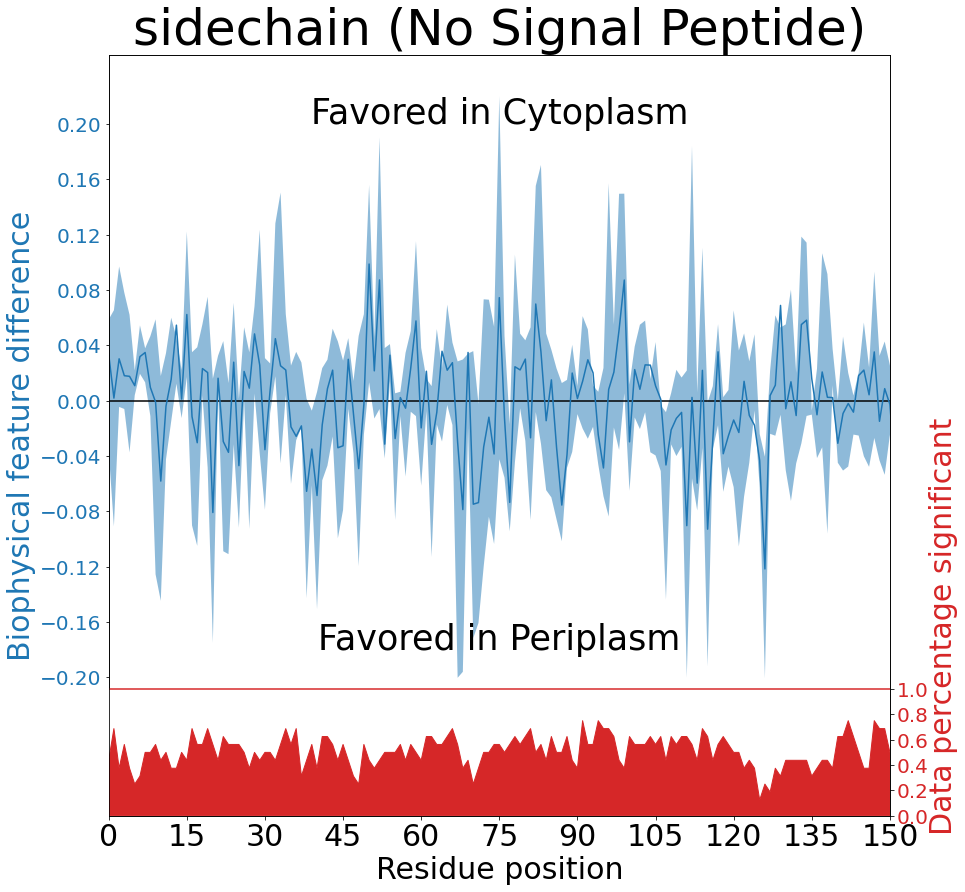

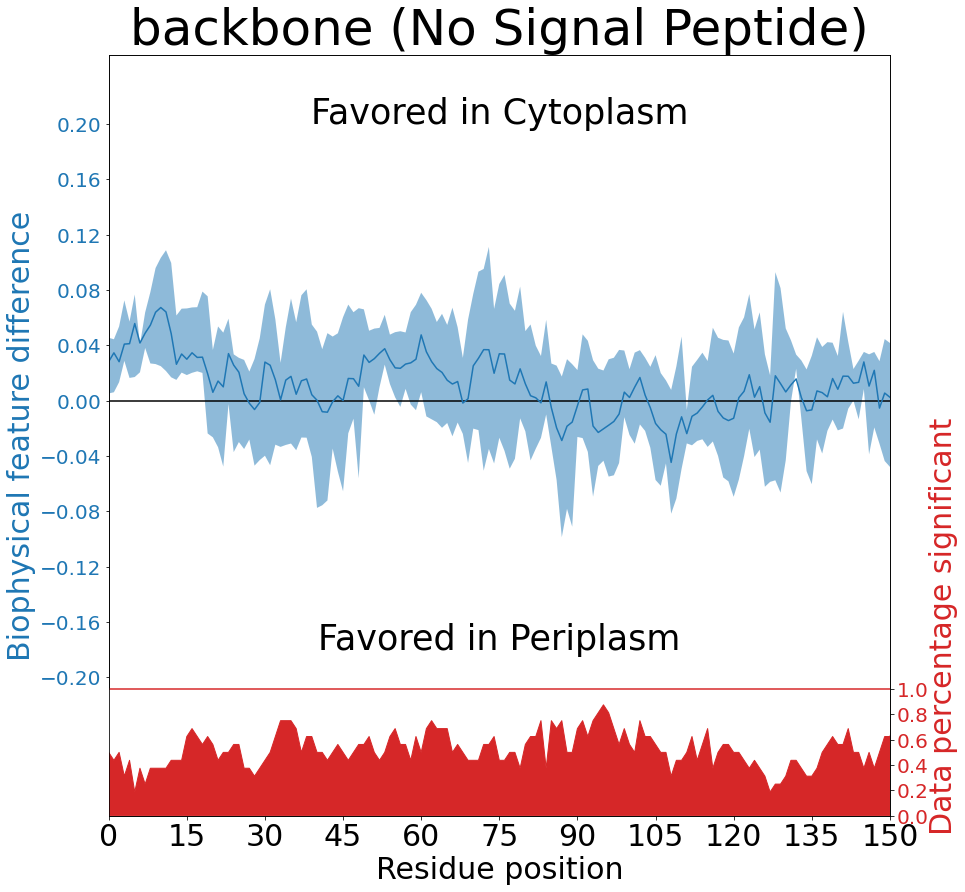

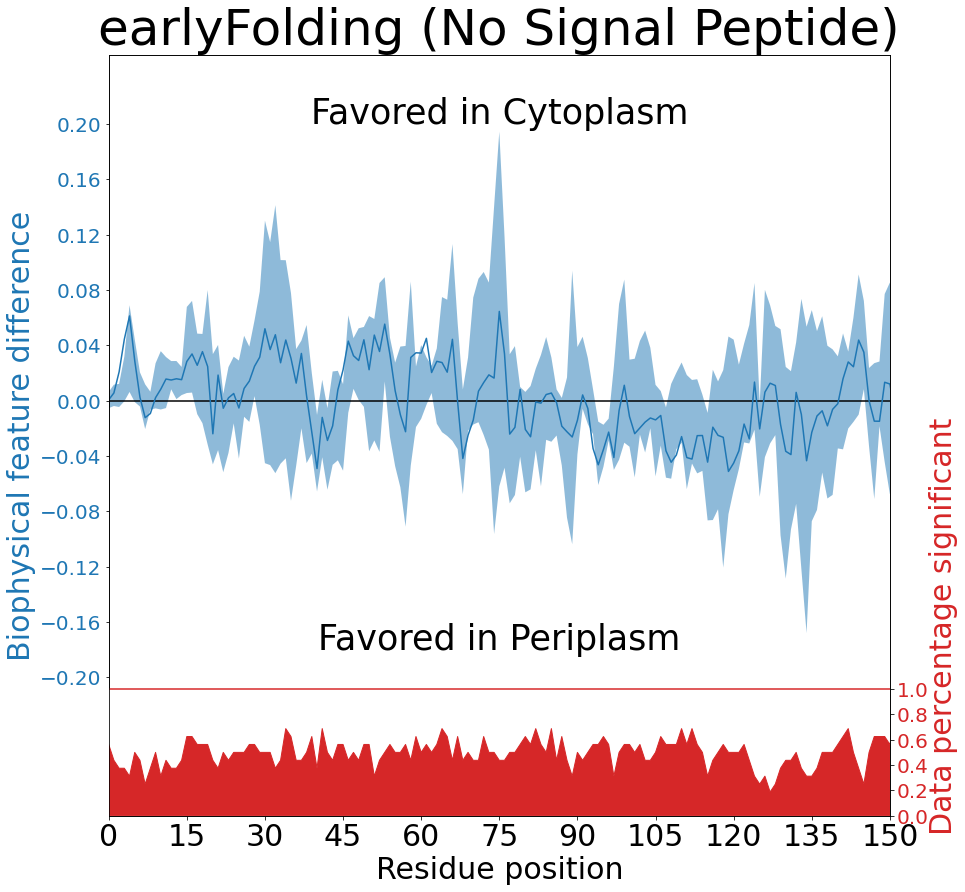

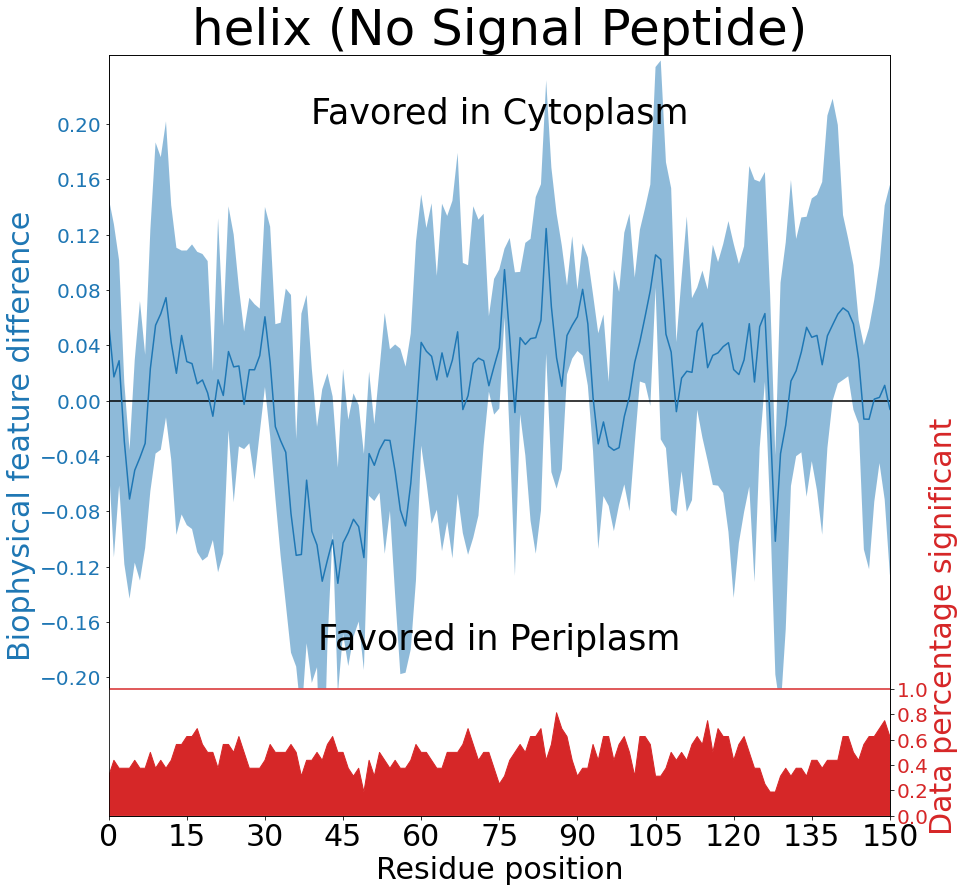

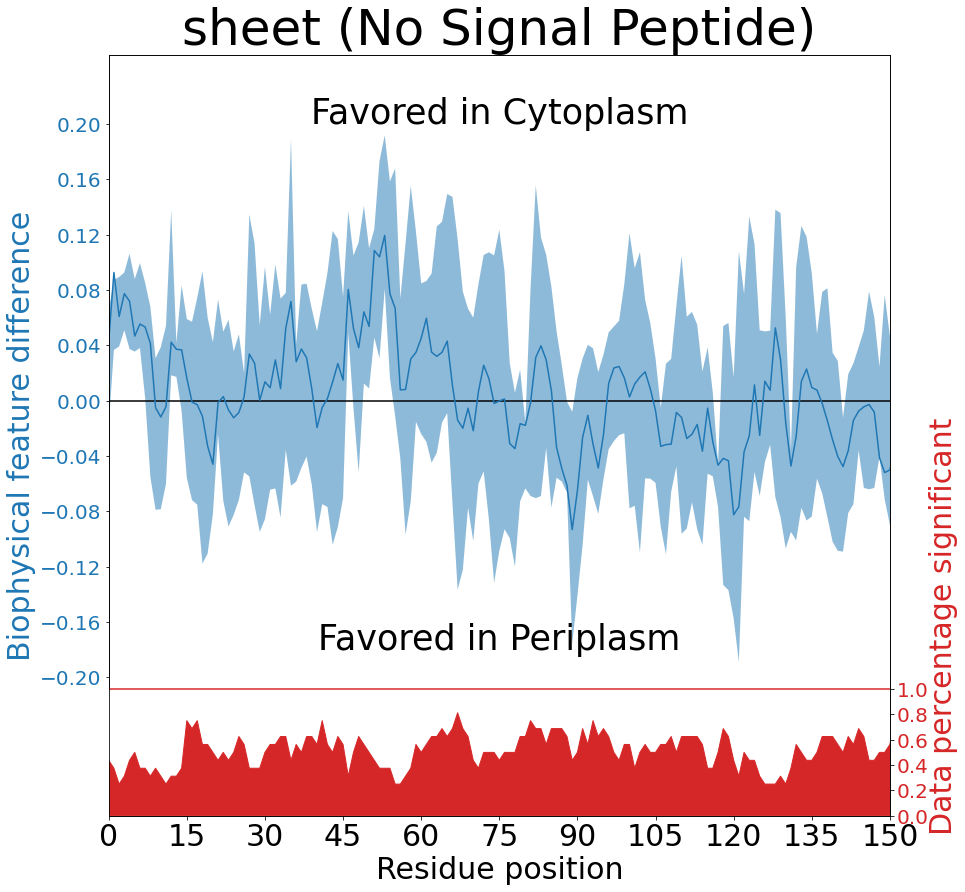

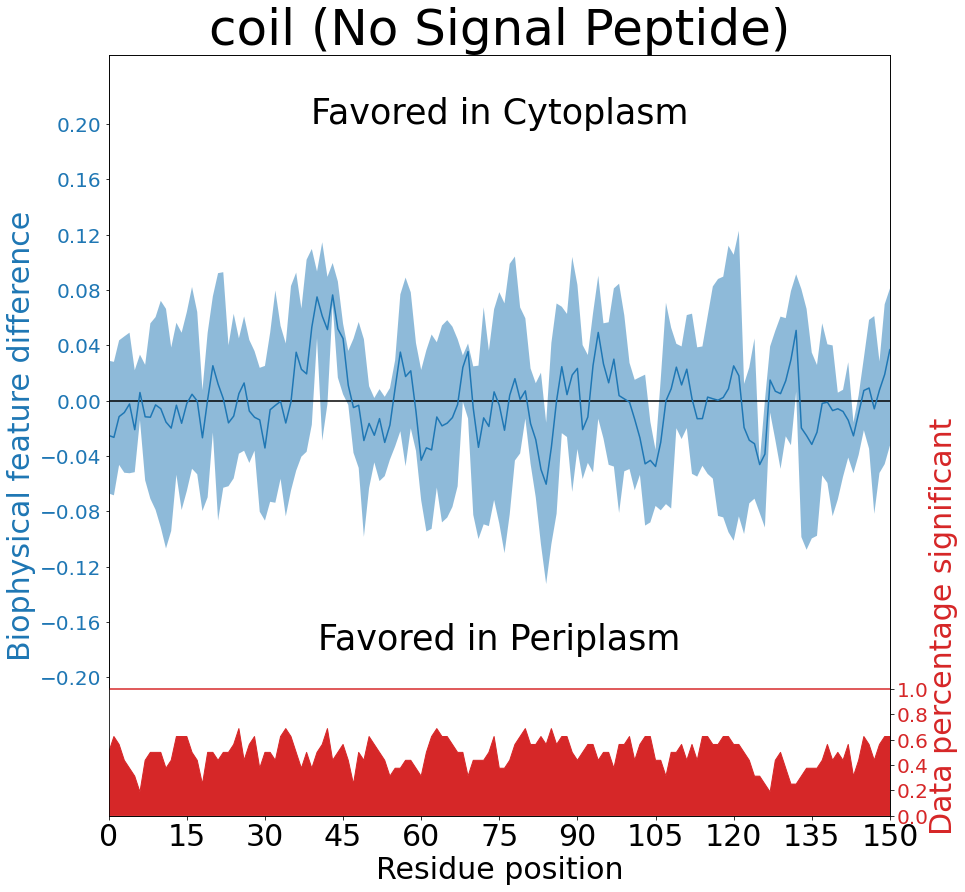

In [118]:
FEATURES = ["{}_diff_medians".format(FEATURE) for FEATURE in ["sidechain","backbone", "earlyFolding", "helix","sheet","coil"]]
XLIM=150
for ID in FEATURES:
    ARRAY = PREDICTIONS_DIC[ID]
    MEDIAN = np.nanmean(ARRAY,axis=0)
    PERCENTILE25 = np.nanpercentile(ARRAY,25,axis=0)
    PERCENTILE75 = np.nanpercentile(ARRAY,75,axis=0)
    
    fig = plt.figure(figsize=(14,14))
    ax1 = fig.add_subplot(111)
    ax1.fill_between(range(len(MEDIAN)),PERCENTILE25,PERCENTILE75,alpha=0.5)
    ax1.plot(MEDIAN)
    ax1.hlines(0,0,XLIM)
    plt.title(ID.split("_")[0]+" (No Signal Peptide)",fontsize=50)
    ax1.set_ylabel('Biophysical feature difference', color="tab:blue" ,fontsize=30)
    plt.yticks(np.arange(-0.20,0.21,0.04), color="tab:blue",fontsize=20)
    plt.ylim((-0.30,0.25))
    ax1.text(XLIM/2, 0.2, 'Favored in Cytoplasm', fontsize=35,horizontalalignment='center')
    ax1.text(XLIM/2, -0.18, 'Favored in Periplasm', fontsize=35,horizontalalignment='center')
    plt.xticks(np.arange(0,XLIM+15,15),fontsize=30)
    plt.xlabel("Residue position",fontsize=30)
    plt.xlim((0,XLIM))
    
    DATA_SIZE = np.count_nonzero(np.nan_to_num(ARRAY),axis=0) / 16
    
    ax2 = ax1.twinx()
    ax2.fill_between(range(len(DATA_SIZE)),np.zeros(len(DATA_SIZE)),np.ones(len(DATA_SIZE)),color="white")
    ax2.fill_between(range(len(DATA_SIZE)),np.zeros(len(DATA_SIZE)),DATA_SIZE,color="tab:red")
    
    ax2.hlines(1,0,XLIM,color="tab:red")
    ax2.set_ylabel('Data percentage significant', color="tab:red",fontsize=30 )
    ax2.yaxis.set_label_coords(1.05,0.25)
    plt.ylim((0,6))
    plt.yticks(np.arange(0,1.2,0.2), color="tab:red",fontsize=20)
    
    fig.savefig("{}_no_sp.pdf".format(ID.split("_")[0]),bbox_inches='tight')
    
    fig.show()

In [120]:
""" Save data to pickle object """
import pickle
with open('data_summary_no_sp.pickle', 'wb') as handle:
    pickle.dump(PREDICTIONS_DIC, handle, protocol=pickle.HIGHEST_PROTOCOL)

(16,)